In [3]:
import pandas as pd
import re
import nltk
import string
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


Βήμα 1: Φόρτωση και Εξέταση Δεδομένων 

In [4]:
# Load dataset from excel file
dataset = pd.read_excel("new_labeled_dataset_withNOs.xlsx", engine="openpyxl")

# Display first few rows of the dataset
print("\nFirst Rows of the Dataset:")
print(dataset.head())

# Display dataset structure and info
print("\nDataset Information:")
dataset.info()  # Directly prints detailed dataset info

# Check for missing values in each column
print("\nMissing Values Per Column:")
print(dataset.isnull().sum())


First Rows of the Dataset:
                                                text  class_label
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...  hate_speech
1                                       Στα τέσσερα.           no
2                                 Στα τέσσερα εσείς.           no
3                                       Στα τέσσερα.           no
4                                            Λοιπόν.           no

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         866 non-null    object
 1   class_label  866 non-null    object
dtypes: object(2)
memory usage: 13.7+ KB

Missing Values Per Column:
text           0
class_label    0
dtype: int64


Βήμα 2: Καθαρισμός Κειμένου

In [5]:

def clean_text(text):
    """
    Cleans text by:
    - Converting to lowercase
    - Removing punctuation
    - Removing numbers
    - Stripping extra spaces
    """
    if not isinstance(text, str):
        return ""  # Return empty string if input is invalid

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    return text

# Apply text cleaning function to dataset
dataset['cleaned_text'] = dataset['text'].apply(clean_text)

# Display sample cleaned text
print("\nSample Cleaned Text:")
print(dataset[['text', 'cleaned_text']].head())



Sample Cleaned Text:
                                                text  \
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...   
1                                       Στα τέσσερα.   
2                                 Στα τέσσερα εσείς.   
3                                       Στα τέσσερα.   
4                                            Λοιπόν.   

                                        cleaned_text  
0  μιας πρότασης σελίδων η οποία δεν έγινε χωρίς ...  
1                                        στα τέσσερα  
2                                  στα τέσσερα εσείς  
3                                        στα τέσσερα  
4                                             λοιπόν  


Exploratory Data Analysis

Class Distribution:
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: class_label, dtype: int64


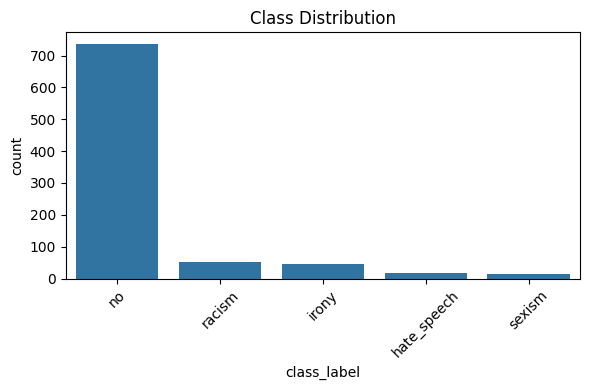


Text Length Statistics:
count    866.000000
mean       9.942263
std        8.717739
min        1.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       68.000000
Name: text_length, dtype: float64


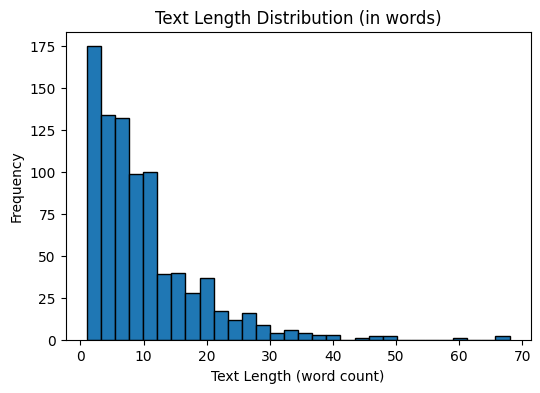


Top 20 Most Frequent Words:
[('να', 322), ('και', 260), ('το', 244), ('δεν', 235), ('είναι', 198), ('που', 152), ('θα', 116), ('η', 109), ('με', 108), ('την', 106), ('τα', 101), ('αυτό', 95), ('ότι', 95), ('για', 90), ('ο', 85), ('εγώ', 75), ('της', 74), ('σε', 73), ('μου', 73), ('από', 69)]


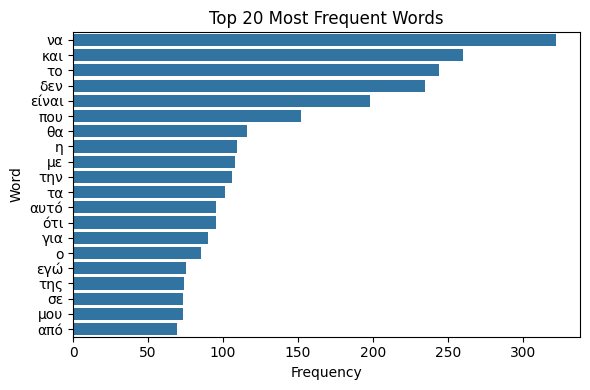

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


# Ensure necessary NLTK resources are downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# --- Class Distribution Analysis ---
print("Class Distribution:")
print(dataset['class_label'].value_counts())

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x='class_label', order=dataset['class_label'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Text Length Analysis ---
# Compute text length (number of words)
dataset['text_length'] = dataset['cleaned_text'].apply(lambda x: len(x.split()))

# Display text length statistics
print("\nText Length Statistics:")
print(dataset['text_length'].describe())

# Plot distribution of text length
plt.figure(figsize=(6, 4))
plt.hist(dataset['text_length'], bins=30, edgecolor='black')
plt.title("Text Length Distribution (in words)")
plt.xlabel("Text Length (word count)")
plt.ylabel("Frequency")
plt.show()

# --- Word Frequency Analysis ---
# Tokenize cleaned text
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# Flatten all tokens into a single list
all_tokens = [word for row in dataset['tokens'] for word in row]
counter = Counter(all_tokens)

# Display the 20 most common words
print("\nTop 20 Most Frequent Words:")
print(counter.most_common(20))

# Plot most frequent words
common_words = counter.most_common(20)
words, freqs = zip(*common_words)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


Βήμα 3: Tokenization και Εφαρμογή Stopwords 

In [7]:

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# --- Tokenization ---
# Tokenize cleaned text
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# --- Remove punctuation and numbers ---
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in string.punctuation and not word.isdigit()]
)

# --- Define and customize Greek stopwords ---
default_stopwords = set(stopwords.words('greek'))

# Additional stopwords based on common Greek words
extra_stopwords = {
    'να', 'και', 'το', 'είναι', 'δεν', 'που', 'την', 'με', 'θα', 'η', 'τα', 'ότι', 'για',
    'μου', 'της', 'αυτό', 'σε', 'από', 'ο', 'Δεν', 'τη', 'τον', 'οι', 'του', 'στην', 'τους',
    'ένα', 'μας', 'στο', 'εγώ', 'έχει', 'σας', 'Και', 'σου', 'τώρα', 'μια', 'Εγώ', 'γιατί',
    'των', 'τι', 'αν', 'αυτή', 'πολύ', 'Να', 'κάτι', 'αυτά', 'Είναι'
}

# Customize stopwords by keeping key terms
custom_stopwords = default_stopwords - {"αυτός", "αυτή", "αυτοί"}
custom_stopwords.update(extra_stopwords)

# Define important words to keep
important_words = {
    "ρατσισμός", "σεξισμός", "ξενοφοβία", "κατά", "δικαιώματα", "προσβολή", "διάκριση",
    "γυναίκα", "άντρας", "μαύρος", "λευκός", "ξένος", "αλλοδαπός"
}

# Ensure important words are not removed
custom_stopwords = {word for word in custom_stopwords if word not in important_words}

print("\nFinal stopwords list:")
print(custom_stopwords)

# --- Remove stopwords from tokens ---
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stopwords]
)

# Display sample tokenized data
print("\nExample tokens after stopword removal:")
print(dataset[['cleaned_text', 'tokens']].head())



Final stopwords list:
{'επ', 'ποιο', 'οὖν', 'τά', 'Εγώ', 'ὑπὸ', 'αὖ', 'ὡσ', 'τοι', 'εγώ', 'ὥς', 'ὅπερ', 'καί', 'μετά', 'οὐ', 'οὕτωσ', 'ὅδε', 'αυτό', 'πως', 'μεθ', 'προσ', 'ὃς', 'που', 'ειμαστε', 'οὐδὲ', 'οὐδείσ', 'γα^', 'οὐχ', 'ἐπὶ', 'σὺ', 'ἑαυτοῦ', 'ποια', 'τινα', 'παρα', 'τε', 'οἱ', 'μην', 'ἡ', "δ'", 'τί', 'ἐστι', 'μας', 'αυτή', 'Είναι', 'ότι', 'μη', 'εκεινα', 'γιατί', 'δή', 'δαὶς', 'μετ', 'δ’', 'ὑμόσ', 'εκεινων', 'ειστε', 'κατ', 'τησ', 'ισωσ', 'γα', 'κἀν', 'τοιοῦτος', 'ἧς', 'ποιοσ', 'εἰ', 'μἐν', 'ἥ', 'οὗτοσ', 'τις', 'αντι', 'από', 'ειμαι', 'στο', 'τίσ', 'αν', 'αυτη', 'μετα', 'της', 'ὡς', 'οὔτε', 'αυτων', 'τοὺς', 'αυτουσ', 'τῆς', 'ὃν', 'εκεινο', 'παρὰ', 'μου', 'ἄλλος', 'ἀπό', 'Δεν', 'εἴ', 'σύν', 'εκεινοι', 'ᾧ', 'τῇ', 'γὰρ', 'ἐφ', 'σόσ', 'εκεινη', 'για', 'τότε', 'ἐκ', 'ἄλλοσ', 'τι', 'μέν', 'έχει', 'η', 'θα', 'ὦ', 'εἰσ', 'εἰμὶ', 'ἣ', 'αλλα', 'σε', 'διὰ', 'ἄν', 'ο', 'ὅθεν', 'ὅτι', 'τους', 'οὕτω', 'ἵνα', 'τῶν', 'πολύ', 'ἐάν', 'οὗτος', 'αὐτὸς', 'ὑπέρ', 'τον', 'τοτε', 'και', 'σύ', 'ποτε',

Βήμα 4: Undersampling της Κλάσης "no" 

In [8]:

# --- Display class distribution before undersampling ---
print("\nClass distribution before undersampling:")
print(dataset['class_label'].value_counts())

# --- Separate "no" class from other classes ---
dataset_no = dataset[dataset['class_label'] == 'no']
dataset_other = dataset[dataset['class_label'] != 'no']

# --- Randomly select 60 samples from the "no" class ---
dataset_no_sampled = dataset_no.sample(n=60, random_state=42)

# --- Combine sampled "no" class with all other classes ---
dataset_balanced = pd.concat([dataset_no_sampled, dataset_other]).reset_index(drop=True)

# --- Display class distribution after undersampling ---
print("\nClass distribution after undersampling:")
print(dataset_balanced['class_label'].value_counts())



Class distribution before undersampling:
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: class_label, dtype: int64

Class distribution after undersampling:
no             60
racism         52
irony          46
hate_speech    17
sexism         15
Name: class_label, dtype: int64


Βήμα 5: Προετοιμασία Κειμένου για TF-IDF 

In [9]:
# Convert tokenized words back into a single string for TF-IDF vectorization
dataset_balanced['processed_text'] = dataset_balanced['tokens'].apply(lambda tokens: ' '.join(tokens))


Βήμα 6: Μετατροπή σε Χαρακτηριστικά με TF-IDF 

In [10]:
# Initialize TF-IDF vectorizer with a max of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Transform processed text into a TF-IDF feature matrix
X = tfidf.fit_transform(dataset_balanced['processed_text'])

# Extract labels for classification
y = dataset_balanced['class_label']

# Print the shape of the resulting TF-IDF matrix
print("\nShape of TF-IDF Feature Matrix:", X.shape)



Shape of TF-IDF Feature Matrix: (190, 920)


Βήμα 7: Μείωση Διαστάσεων με PCA και Οπτικοποίηση 

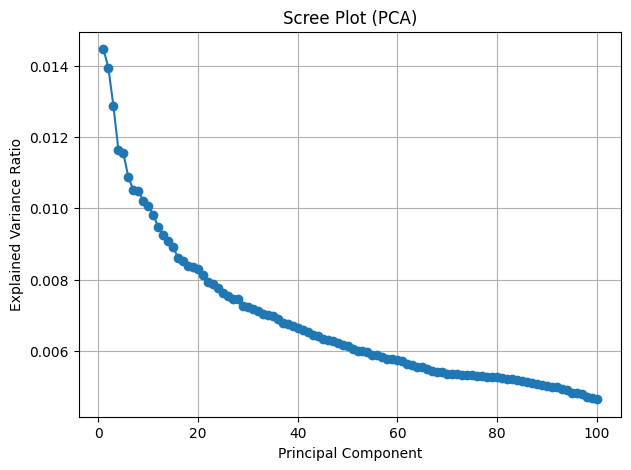

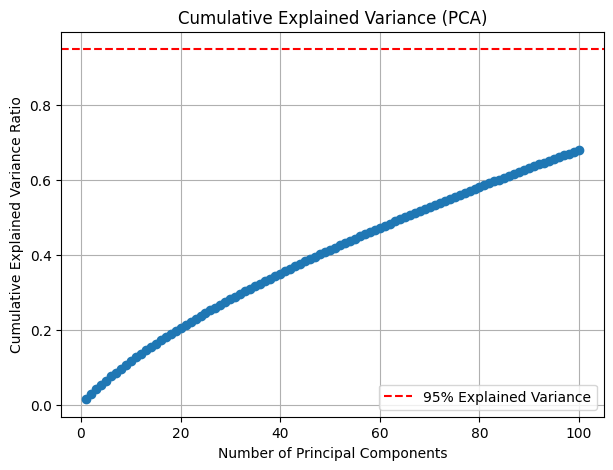

In [11]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=100, random_state=42)
X_reduced = pca.fit_transform(X.toarray())  # Convert sparse matrix to dense for PCA

# Explained variance ratio for each principal component
exp_var_ratio = pca.explained_variance_ratio_

# --- Scree Plot: Explained variance per principal component ---
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(exp_var_ratio) + 1), exp_var_ratio, marker='o', linestyle='-')
plt.title('Scree Plot (PCA)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# --- Cumulative Explained Variance Plot ---
cum_exp_var = np.cumsum(exp_var_ratio)
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(cum_exp_var) + 1), cum_exp_var, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.title('Cumulative Explained Variance (PCA)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()


Βήμα 8: Ταξινόμηση με Leave-One-Out Cross-Validation 

LOGISTIC REGRESSION PCA - NO SMOTE

In [12]:

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Create a pipeline integrating PCA and Logistic Regression
pipeline = Pipeline([
    ('pca', PCA(n_components=60, random_state=42)),  # Reduce dimensionality to 60 components
    ('clf', LogisticRegression(max_iter=1000))
])

# Apply LOO-CV and predict labels
y_pred = cross_val_predict(pipeline, X.toarray(), y, cv=loo)  # Convert X to dense array for PCA

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Compute performance metrics
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display performance results
print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# --- Confusion Matrix Visualization ---
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()



Performance Metrics:
Precision (macro): 0.2282
Recall (macro):    0.2441
F1-score (macro):  0.1922

Classification Report:
              precision    recall  f1-score   support

 hate_speech       0.00      0.00      0.00        17
       irony       0.29      0.04      0.08        46
          no       0.34      0.85      0.49        60
      racism       0.52      0.33      0.40        52
      sexism       0.00      0.00      0.00        15

    accuracy                           0.37       190
   macro avg       0.23      0.24      0.19       190
weighted avg       0.32      0.37      0.28       190



/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

LOGISTIC REGRESSION PCA CORRECT SMOTE 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, classification_report, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ---  Initialize Leave-One-Out Cross-Validation ---
loo = LeaveOneOut()

# ---  Set up PCA and Logistic Regression ---
pca = PCA(n_components=60, random_state=42)  # Reduce dimensionality
log_reg = LogisticRegression(max_iter=1000, random_state=42)  # Logistic Regression model

# ---  Store actual and predicted values ---
Y_true = []
Y_pred = []

# ---  Apply LOO-CV with SMOTE ---
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index].toarray(), X[test_index].toarray()  # Convert sparse to dense
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Convert labels to pandas Series

    # ---  Apply SMOTE to the training set only ---
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # ---  Apply PCA transformation ---
    X_train_resampled = pca.fit_transform(X_train_resampled)  # Fit PCA on training set
    X_test_pca = pca.transform(X_test)  # Transform test set (without fitting)

    # ---  Train Logistic Regression on resampled training set ---
    log_reg.fit(X_train_resampled, y_train_resampled)

    # ---  Predict on test set ---
    y_pred = log_reg.predict(X_test_pca)

    # ---  Store actual and predicted values ---
    Y_true.append(y_test.item())  # Convert single-value Series to scalar
    Y_pred.append(y_pred[0])  # Extract prediction

# ---  Compute Confusion Matrix ---
cm = confusion_matrix(Y_true, Y_pred)

# ---  Compute and Print Performance Metrics ---
precision = precision_score(Y_true, Y_pred, average='macro')
recall = recall_score(Y_true, Y_pred, average='macro')
f1 = f1_score(Y_true, Y_pred, average='macro')

print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# ---  Print Classification Report ---
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred))

# ---  Visualize Confusion Matrix ---
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()


/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn 

SVM PCA - NO SMOTE


Performance Metrics:
Precision (macro): 0.2110
Recall (macro):    0.2485
F1-score (macro):  0.1962

Classification Report:
              precision    recall  f1-score   support

 hate_speech       0.00      0.00      0.00        17
       irony       0.17      0.02      0.04        46
          no       0.34      0.82      0.48        60
      racism       0.55      0.40      0.47        52
      sexism       0.00      0.00      0.00        15

    accuracy                           0.37       190
   macro avg       0.21      0.25      0.20       190
weighted avg       0.30      0.37      0.29       190


Confusion Matrix:
[[ 0  1 13  3  0]
 [ 0  1 41  4  0]
 [ 0  2 49  9  0]
 [ 0  2 29 21  0]
 [ 0  0 14  1  0]]


/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

<Figure size 600x500 with 0 Axes>

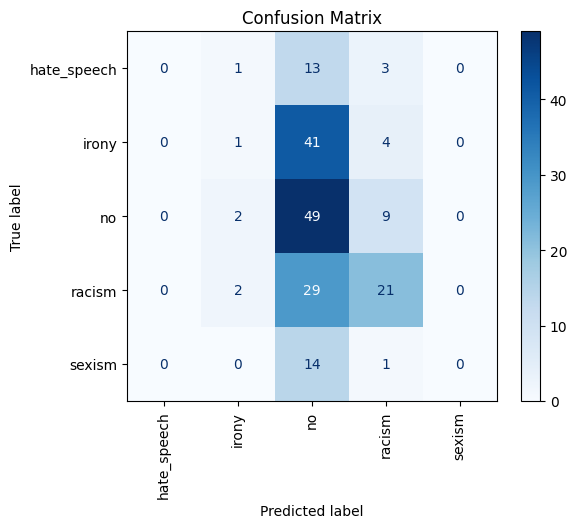

In [13]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, classification_report, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Create a pipeline integrating PCA and SVM
pipeline = Pipeline([
    ('pca', PCA(n_components=100, random_state=42)),  # Reduce dimensionality to 100 components
    ('clf', SVC(kernel='linear', C=1.0, random_state=42))  # Linear SVM Classifier
])

# Apply LOO-CV and predict labels
y_pred = cross_val_predict(pipeline, X.toarray(), y, cv=loo)  # Convert sparse TF-IDF matrix to dense format for PCA

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Compute performance metrics
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display performance results
print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# --- Confusion Matrix Visualization ---
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()


SVM PCA WITH CORRECT SMOTE

/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/annatolia/Desktop/myenv/ml/in_here/myenv_py39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn 


Performance Metrics:
Precision (macro): 0.6508
Recall (macro):    0.3438
F1-score (macro):  0.3519

Classification Report:
              precision    recall  f1-score   support

 hate_speech       1.00      0.06      0.11        17
       irony       0.25      0.11      0.15        46
          no       0.38      0.83      0.52        60
      racism       0.62      0.38      0.48        52
      sexism       1.00      0.33      0.50        15

    accuracy                           0.43       190
   macro avg       0.65      0.34      0.35       190
weighted avg       0.52      0.43      0.38       190


Confusion Matrix:
[[ 1  1 13  2  0]
 [ 0  5 36  5  0]
 [ 0  6 50  4  0]
 [ 0  8 24 20  0]
 [ 0  0  9  1  5]]


<Figure size 600x500 with 0 Axes>

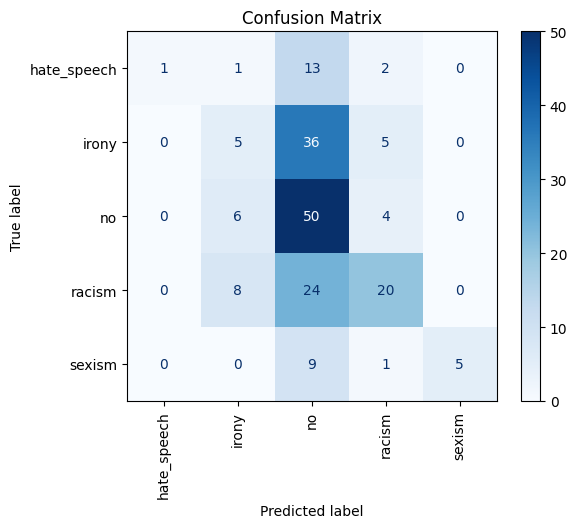

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, classification_report, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- Initialize Leave-One-Out Cross-Validation ---
loo = LeaveOneOut()

# --- Set up PCA and SVM ---
pca = PCA(n_components=100, random_state=42)  # Reduce dimensionality
svm = SVC(kernel='linear', C=1.0, random_state=42)  # Linear SVM Classifier

# --- Store actual and predicted values ---
Y_true = []
Y_pred = []

# ---  Apply LOO-CV with SMOTE ---
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index].toarray(), X[test_index].toarray()  # Convert sparse to dense
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Convert labels to pandas Series

    # ---  Apply SMOTE to the training set only ---
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # ---  Apply PCA transformation ---
    X_train_resampled = pca.fit_transform(X_train_resampled)  # Fit PCA on training set
    X_test_pca = pca.transform(X_test)  # Transform test set (without fitting)

    # ---  Train SVM on resampled training set ---
    svm.fit(X_train_resampled, y_train_resampled)

    # ---  Predict on test set ---
    y_pred = svm.predict(X_test_pca)

    # ---  Store actual and predicted values ---
    Y_true.append(y_test.item())  # Convert single-value Series to scalar
    Y_pred.append(y_pred[0])  # Extract prediction

# ---  Compute Confusion Matrix ---
cm = confusion_matrix(Y_true, Y_pred)

# ---  Compute and Print Performance Metrics ---
precision = precision_score(Y_true, Y_pred, average='macro')
recall = recall_score(Y_true, Y_pred, average='macro')
f1 = f1_score(Y_true, Y_pred, average='macro')

print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# ---  Print Classification Report ---
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred))

# ---  Visualize Confusion Matrix ---
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()


 NAIVE BASE PCA - NO SMOTE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, classification_report, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Create a pipeline integrating PCA and Naïve Bayes
pipeline = Pipeline([
    ('pca', PCA(n_components=150, random_state=42)),  # Reduce dimensionality to 150 components
    ('clf', GaussianNB())  # Naïve Bayes Classifier
])

# Apply LOO-CV and predict labels
y_pred = cross_val_predict(pipeline, X.toarray(), y, cv=loo)  # Convert sparse TF-IDF matrix to dense format for PCA

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Compute performance metrics
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

# Display performance results
print("\nPerformance Metrics:")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")
print(f"F1-score (macro):  {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y, y_pred))

# --- Confusion Matrix Visualization ---
print("\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')

# Improve visualization aesthetics
plt.title("Confusion Matrix")
plt.grid(False)  # Remove grid for clarity
plt.show()
